In [ ]:
!pip install opendatasets

In [ ]:
!pip install jovian

     |████████████████████████████████| 71kB 1.9MB/s 
  Created wheel for uuid: filename=uuid-1.30-cp37-none-any.whl size=6503 sha256=5e8da8f5af23ed36f1e909c04969c9991cac66d8cd57143bc600614ef5bac037
  Stored in directory: /root/.cache/pip/wheels/2a/80/9b/015026567c29fdffe31d91edbe7ba1b17728db79194fca1f21
Successfully built uuid


In [ ]:
import os
import torch
import shutil
import jovian
import pandas as pd
import numpy as np
import opendatasets as od
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from PIL import Image
from copy import copy
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/ikarus777/best-artworks-of-all-time')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kumaranmasilamani
Your Kaggle Key: ··········


  0%|          | 0.00/2.29G [00:00<?, ?B/s]

100%|██████████| 2.29G/2.29G [01:02<00:00, 39.5MB/s]


## Preparing the Data


In [ ]:
artistdata = pd.read_csv('best-artworks-of-all-time/artists.csv')
artistdata.columns

Index(['id', 'name', 'years', 'genre', 'nationality', 'bio', 'wikipedia',
       'paintings'],
      dtype='object')

In [ ]:
artistdata[artistdata['paintings'] < 50]

,id,name,years,genre,nationality,bio,wikipedia,paintings
38,38,Paul Cezanne,1839 – 1906,Post-Impressionism,French,Paul Cézanne (US: or UK: ; French: [pɔl sezan...,https://en.wikipedia.org/wiki/Paul_Cézanne,47
39,39,Eugene Delacroix,1798 – 1863,Romanticism,French,Ferdinand Victor Eugène Delacroix (; French: [...,https://en.wikipedia.org/wiki/Eugène_Delacroix,31
41,41,Georges Seurat,1859 – 1891,Post-Impressionism,French,Georges-Pierre Seurat (French: [ʒɔʁʒ pjɛʁ sœʁa...,https://en.wikipedia.org/wiki/Georges_Seurat,43
48,48,Michelangelo,1475 – 1564,High Renaissance,Italian,Michelangelo di Lodovico Buonarroti Simoni or ...,https://en.wikipedia.org/wiki/Michelangelo,49
49,49,Jackson Pollock,1912 – 1956,Abstract Expressionism,American,"Paul Jackson Pollock (; January 28, 1912 – Aug...",http://en.wikipedia.org/wiki/Jackson_Pollock,24


In [ ]:
artists = artistdata.drop(artistdata[artistdata['paintings'] < 50].index)

In [ ]:
artists = artists.sort_values(by=['name'])
artists = artists[['name', 'genre', 'nationality', 'paintings']]
artists['class_weight'] = max(artists.paintings)/artists.paintings
print(len(artists))
artists.head()

45


,name,genre,nationality,paintings,class_weight
19,Albrecht Dürer,Northern Renaissance,German,328,2.673780
20,Alfred Sisley,Impressionism,"French,British",259,3.386100
0,Amedeo Modigliani,Expressionism,Italian,193,4.544041
7,Andrei Rublev,Byzantine Art,Russian,99,8.858586
45,Andy Warhol,Pop Art,American,181,4.845304


In [ ]:
weights = artists['class_weight']
class_weights = torch.FloatTensor(weights).cuda()

In [ ]:
imgdir = 'best-artworks-of-all-time/images/images'

In [ ]:
os.rename(imgdir+'/Albrecht_Du╠êrer', imgdir+'/Albrecht_Dürer')

In [ ]:
shutil.rmtree(imgdir+'/Albrecht_DuΓòá├¬rer')
shutil.rmtree(imgdir+'/Paul_Cezanne')
shutil.rmtree(imgdir+'/Eugene_Delacroix')
shutil.rmtree(imgdir+'/Georges_Seurat')
shutil.rmtree(imgdir+'/Michelangelo')
shutil.rmtree(imgdir+'/Jackson_Pollock')

#### Loading the Data and Applying Transforms

In [ ]:
train_tfms = T.Compose([T.Resize((128, 128)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()])

val_tfms = T.Compose([T.Resize((128, 128)),
                      T.ToTensor()])

In [ ]:
full_dataset = ImageFolder(imgdir)
classes = full_dataset.classes

In [ ]:
train_size = int(0.8*(len(full_dataset)))
val_size = len(full_dataset) - train_size
batch_size = 128

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])
train_ds.dataset = copy(full_dataset)

In [ ]:
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = val_tfms

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
# calculating mean and stdev for all channels in train_dl
pop_mean = []
pop_std0 = []
pop_std1 = []
for img, label in tqdm(train_dl):
    # shape (batch_size, 3, height, width)
    numpy_image = img.numpy()

    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std0 = np.std(numpy_image, axis=(0, 2, 3))
    batch_std1 = np.std(numpy_image, axis=(0, 2, 3), ddof=1)

    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)

In [ ]:
train_tfms = T.Compose([T.Resize((128, 128)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(pop_mean, pop_std0)])

val_tfms = T.Compose([T.Resize((128, 128)),
                      T.ToTensor(),
                      T.Normalize(pop_mean, pop_std0)])

train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = val_tfms

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0, 1))
        break

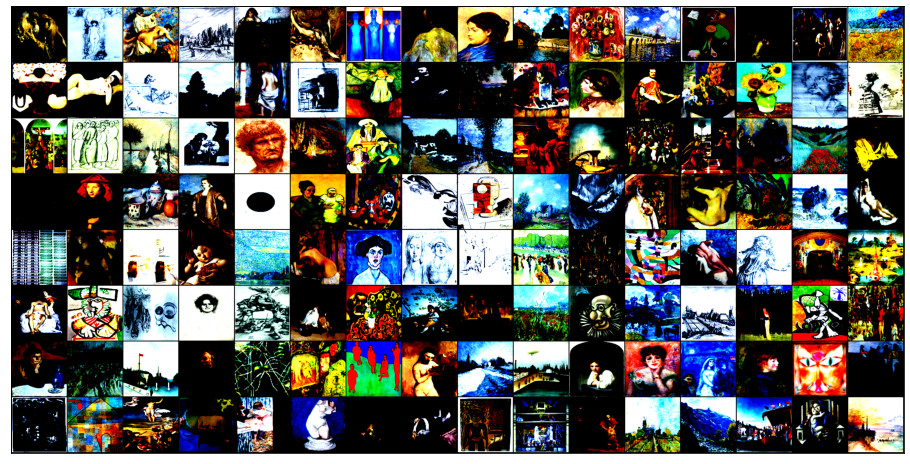

In [ ]:
show_batch(train_dl)

In [ ]:
project_name = 'Art Image Classification Publication code'

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


### Using GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(
            out, labels, weight=class_weights)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(
            out, labels, weight=class_weights)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(
                result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ArtModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        self.network.fc = nn.Sequential(nn.Linear(self.network.fc.in_features, 512),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        return self.network(xb)

## Training the Model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = ArtModel(len(classes))
to_device(model, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ArtModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.01116071455180645, 'val_loss': 3.8294286727905273}]

In [ ]:
epochs = 40
lr = 0.01
weight_decay = 0.0005
opt_func = torch.optim.SGD

In [ ]:

history += fit_one_cycle(epochs, lr, model, train_dl, valid_dl,
                         weight_decay=weight_decay,
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00056, train_loss: 3.7821, val_loss: 3.6767, val_acc: 0.0758



Epoch [1],last_lr: 0.00103, train_loss: 3.5013, val_loss: 3.2887, val_acc: 0.2476



Epoch [2],last_lr: 0.00179, train_loss: 2.7876, val_loss: 2.3951, val_acc: 0.3539



Epoch [3],last_lr: 0.00279, train_loss: 1.7931, val_loss: 1.7426, val_acc: 0.4741



Epoch [4],last_lr: 0.00394, train_loss: 1.0647, val_loss: 1.4658, val_acc: 0.5680



Epoch [5],last_lr: 0.00519, train_loss: 0.5943, val_loss: 1.4214, val_acc: 0.6122



Epoch [6],last_lr: 0.00643, train_loss: 0.3416, val_loss: 1.3209, val_acc: 0.6381



Epoch [7],last_lr: 0.00759, train_loss: 0.1962, val_loss: 1.4070, val_acc: 0.6585



Epoch [8],last_lr: 0.00859, train_loss: 0.1270, val_loss: 1.3111, val_acc: 0.6777



Epoch [9],last_lr: 0.00935, train_loss: 0.0657, val_loss: 1.3908, val_acc: 0.6998



Epoch [10],last_lr: 0.00984, train_loss: 0.0373, val_loss: 1.3144, val_acc: 0.7184



Epoch [11],last_lr: 0.01000, train_loss: 0.0259, val_loss: 1.7736, val_acc: 0.6450



Epoch [12],last_lr: 0.00997, train_loss: 0.0373, val_loss: 1.4636, val_acc: 0.7005



Epoch [13],last_lr: 0.00987, train_loss: 0.0227, val_loss: 1.4540, val_acc: 0.7037



Epoch [14],last_lr: 0.00972, train_loss: 0.0132, val_loss: 1.3877, val_acc: 0.7097



Epoch [15],last_lr: 0.00950, train_loss: 0.0072, val_loss: 1.3919, val_acc: 0.7173



Epoch [16],last_lr: 0.00923, train_loss: 0.0053, val_loss: 1.4001, val_acc: 0.7132



Epoch [17],last_lr: 0.00891, train_loss: 0.0044, val_loss: 1.3926, val_acc: 0.7227



Epoch [18],last_lr: 0.00854, train_loss: 0.0036, val_loss: 1.3992, val_acc: 0.7192



Epoch [19],last_lr: 0.00812, train_loss: 0.0032, val_loss: 1.3891, val_acc: 0.7227



Epoch [20],last_lr: 0.00766, train_loss: 0.0031, val_loss: 1.3985, val_acc: 0.7253



Epoch [21],last_lr: 0.00717, train_loss: 0.0026, val_loss: 1.3855, val_acc: 0.7214



Epoch [22],last_lr: 0.00665, train_loss: 0.0024, val_loss: 1.3878, val_acc: 0.7225



Epoch [23],last_lr: 0.00611, train_loss: 0.0024, val_loss: 1.4010, val_acc: 0.7260



Epoch [24],last_lr: 0.00556, train_loss: 0.0021, val_loss: 1.3975, val_acc: 0.7306



Epoch [25],last_lr: 0.00500, train_loss: 0.0021, val_loss: 1.4021, val_acc: 0.7300



Epoch [26],last_lr: 0.00444, train_loss: 0.0019, val_loss: 1.3850, val_acc: 0.7275



Epoch [27],last_lr: 0.00389, train_loss: 0.0020, val_loss: 1.3947, val_acc: 0.7309



Epoch [28],last_lr: 0.00335, train_loss: 0.0019, val_loss: 1.3886, val_acc: 0.7299



Epoch [29],last_lr: 0.00283, train_loss: 0.0019, val_loss: 1.3742, val_acc: 0.7288



Epoch [30],last_lr: 0.00234, train_loss: 0.0018, val_loss: 1.3886, val_acc: 0.7271



Epoch [31],last_lr: 0.00188, train_loss: 0.0017, val_loss: 1.4037, val_acc: 0.7238



Epoch [32],last_lr: 0.00146, train_loss: 0.0016, val_loss: 1.3908, val_acc: 0.7285



Epoch [33],last_lr: 0.00109, train_loss: 0.0016, val_loss: 1.3875, val_acc: 0.7311



Epoch [34],last_lr: 0.00077, train_loss: 0.0016, val_loss: 1.4031, val_acc: 0.7277



Epoch [35],last_lr: 0.00050, train_loss: 0.0016, val_loss: 1.3911, val_acc: 0.7281



Epoch [36],last_lr: 0.00028, train_loss: 0.0016, val_loss: 1.3865, val_acc: 0.7253



Epoch [37],last_lr: 0.00013, train_loss: 0.0017, val_loss: 1.3971, val_acc: 0.7299



Epoch [38],last_lr: 0.00003, train_loss: 0.0016, val_loss: 1.3921, val_acc: 0.7281



Epoch [39],last_lr: 0.00000, train_loss: 0.0015, val_loss: 1.3880, val_acc: 0.7299


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

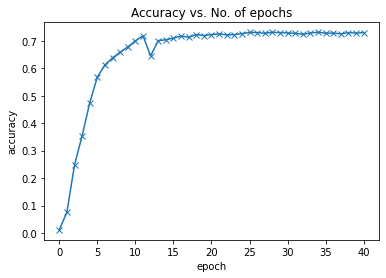

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

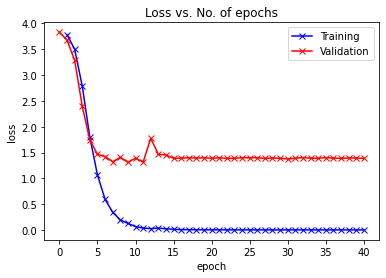

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

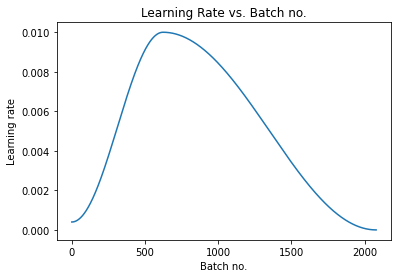

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), 'ArtClassification_Resnet50_Normalized.pth')

## Testing with Individual Images


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return full_dataset.classes[preds[0].item()]

Label: Jan_van_Eyck , Predicted: Jan_van_Eyck


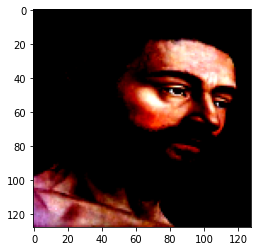

In [ ]:
img, label = val_ds[30]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

Label: Henri_Rousseau , Predicted: Henri_Rousseau


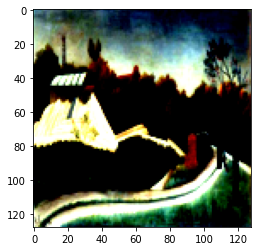

In [ ]:
img, label = val_ds[1000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

Label: Sandro_Botticelli , Predicted: Sandro_Botticelli


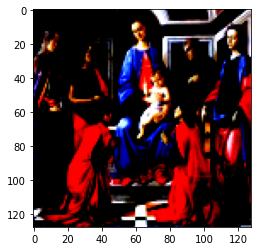

In [ ]:
img, label = val_ds[440]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

Label: Alfred_Sisley , Predicted: Alfred_Sisley


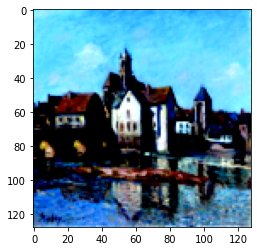

In [ ]:
img, label = val_ds[40]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

Label: Amedeo_Modigliani , Predicted: Amedeo_Modigliani


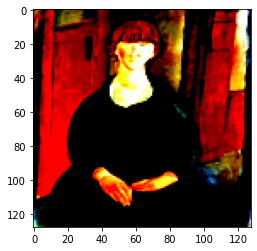

In [ ]:
img, label = val_ds[720]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

Label: Pieter_Bruegel , Predicted: Pieter_Bruegel


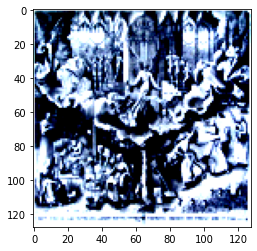

In [ ]:
img, label = val_ds[1650]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', full_dataset.classes[label],
      ', Predicted:', predict_image(img, model))

### Test Set

In [ ]:
test_loader = DeviceDataLoader(DataLoader(val_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.729905903339386, 'val_loss': 1.388037919998169}